# 🚀 Mô Hình Dự Báo Giá Bitcoin Với BiLSTM

Notebook này hướng dẫn bạn từng bước để xây dựng và huấn luyện mô hình dự báo giá Bitcoin.

## 📦 0. Setup & Cấu Hình

Cấu hình TensorFlow và import các thư viện cần thiết.

In [1]:
# Standard library imports
import logging
import os
import sys
import warnings
from pathlib import Path

# Suppress TensorFlow warnings BEFORE importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Chỉ hiển thị ERROR
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Tắt oneDNN warnings

# Suppress Python warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='.*np.object.*')
warnings.filterwarnings('ignore', message='.*oneDNN.*')
warnings.filterwarnings('ignore', message='.*CUDA.*')
warnings.filterwarnings('ignore', message='.*Could not find cuda.*')
warnings.filterwarnings('ignore', message='.*cuda drivers.*')
warnings.filterwarnings('ignore', message='.*GPU will not be used.*')

# Third-party imports (must be after env vars for TensorFlow)
import numpy as np  # noqa: E402
import polars as pl  # noqa: E402

# Import và suppress TensorFlow logger ngay lập tức
try:
    import tensorflow as tf  # noqa: E402
    tf.get_logger().setLevel('ERROR')
    # Suppress stderr output từ TensorFlow
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
except ImportError:
    pass  # TensorFlow chưa được cài đặt

# Setup project path (notebook runs from notebooks/, need to go up one level)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Local imports
from src.runtime import (  # noqa: E402
    configure_tensorflow_runtime,
    print_tensorflow_info,
    set_random_seed
)

# Cấu hình TensorFlow cho CPU AMD
configure_tensorflow_runtime(
    intra_op_threads=12,
    inter_op_threads=2,
    enable_xla=True
)

# In thông tin TensorFlow
print_tensorflow_info()

⚙️  CẤU HÌNH TENSORFLOW RUNTIME
Intra-op threads: 12
Inter-op threads: 2
XLA enabled: True
Use GPU: False


📋 THÔNG TIN TENSORFLOW
TensorFlow version: 2.20.0
Keras version: 3.13.0
Built with CUDA: True
ℹ️  Không tìm thấy GPU, sẽ dùng CPU
GPU available: False
Intra-op threads: 12
Inter-op threads: 2



## 🔧 1. Chọn Preset

Chọn một trong các preset có sẵn hoặc cấu hình thủ công:

In [2]:
# ==================== CHỌN PRESET ====================
# Chọn preset từ danh sách bên dưới, hoặc set PRESET_NAME = None để cấu hình thủ công
#
# Preset Scalping (15m - siêu ngắn hạn):
# - 'scalping-ultra-fast': 10k dòng, window=24 (6h), epochs=5, lstm=[16], dense=[] - Scalping cực nhanh
# - 'scalping-fast': 20k dòng, window=48 (12h), epochs=10, lstm=[32,16], dense=[16] - Scalping nhanh
#
# Preset Intraday (15m - ngắn hạn):
# - 'intraday-light': 30k dòng, window=96 (1d), epochs=15, lstm=[32,16], dense=[16] - Intraday nhẹ
# - 'intraday-balanced': 50k dòng, window=144 (1.5d), epochs=25, lstm=[64,32], dense=[32] - Intraday cân bằng
#
# Preset Swing (15m - trung hạn):
# - 'swing-fast': 70k dòng, window=240 (2.5d), epochs=30, lstm=[64,32], dense=[32] - Swing nhanh
# - 'swing-balanced': 100k dòng, window=384 (4d), epochs=50, lstm=[128,64,32], dense=[64,32] - Swing cân bằng
#
# Preset Long-term & Production (15m):
# - 'long-term': 150k dòng, window=576 (6d), epochs=80, lstm=[256,128,64,32], dense=[128,64] - Dự đoán dài hạn
# - 'production': 200k dòng, window=768 (8d), epochs=100, lstm=[256,128,64,32], dense=[128,64,32] - Production chất lượng cao nhất
#
# Preset 30k Dataset (15m - Window size từ ngắn đến dài hạn, intra_op_threads=12):
# - '30k-w24': 30k dòng, window=24 (6h), epochs=15, lstm=[32,16], dense=[16] - Ngắn hạn cực nhanh
# - '30k-w48': 30k dòng, window=48 (12h), epochs=15, lstm=[32,16], dense=[16] - Ngắn hạn nhanh
# - '30k-w72': 30k dòng, window=72 (18h), epochs=20, lstm=[32,16], dense=[16] - Ngắn hạn
# - '30k-w96': 30k dòng, window=96 (1d), epochs=20, lstm=[64,32], dense=[32] - Ngắn hạn cân bằng (kết quả tốt)
# - '30k-w144': 30k dòng, window=144 (1.5d), epochs=25, lstm=[64,32], dense=[32] - Trung hạn ngắn
# - '30k-w192': 30k dòng, window=192 (2d), epochs=25, lstm=[64,32], dense=[32] - Trung hạn
# - '30k-w240': 30k dòng, window=240 (2.5d), epochs=30, lstm=[64,32], dense=[32] - Trung hạn cân bằng
# - '30k-w336': 30k dòng, window=336 (3.5d), epochs=30, lstm=[128,64,32], dense=[64,32] - Trung hạn dài
# - '30k-w480': 30k dòng, window=480 (5d), epochs=40, lstm=[128,64,32], dense=[64,32] - Dài hạn ngắn
# - '30k-w672': 30k dòng, window=672 (7d), epochs=40, lstm=[128,64,32], dense=[64,32] - Dài hạn
#
# Preset Legacy (cho các timeframe khác):
# - 'default': 50k dòng 15m (default config)
# - 'fast': 20k dòng 15m (test nhanh)
# - '1h-light': 10k dòng 1h
# - '4h-balanced': 2k dòng 4h
#
# Set PRESET_NAME = None để dùng cấu hình thủ công ở cell bên dưới

PRESET_NAME = '30k-w144'  # Đổi tên preset ở đây, hoặc None để cấu hình thủ công

# Import preset functions
from src import (  # noqa: E402
    Config,
    # Scalping presets
    get_scalping_ultra_fast_config,
    get_scalping_fast_config,
    # Intraday presets
    get_intraday_light_config,
    get_intraday_balanced_config,
    # Swing presets
    get_swing_fast_config,
    get_swing_balanced_config,
    # Long-term & Production presets
    get_long_term_config,
    get_production_config,
    # 30k dataset presets
    get_30k_w24_config,
    get_30k_w48_config,
    get_30k_w72_config,
    get_30k_w96_config,
    get_30k_w144_config,
    get_30k_w192_config,
    get_30k_w240_config,
    get_30k_w336_config,
    get_30k_w480_config,
    get_30k_w672_config,
    # Legacy presets
    get_default_config,
    get_fast_config,
    get_1h_light_config,
    get_4h_balanced_config,
)

# Map preset name với function
PRESET_MAP = {
    # Scalping presets
    'scalping-ultra-fast': get_scalping_ultra_fast_config,
    'scalping-fast': get_scalping_fast_config,
    # Intraday presets
    'intraday-light': get_intraday_light_config,
    'intraday-balanced': get_intraday_balanced_config,
    # Swing presets
    'swing-fast': get_swing_fast_config,
    'swing-balanced': get_swing_balanced_config,
    # Long-term & Production presets
    'long-term': get_long_term_config,
    'production': get_production_config,
    # 30k dataset presets
    '30k-w24': get_30k_w24_config,
    '30k-w48': get_30k_w48_config,
    '30k-w72': get_30k_w72_config,
    '30k-w96': get_30k_w96_config,
    '30k-w144': get_30k_w144_config,
    '30k-w192': get_30k_w192_config,
    '30k-w240': get_30k_w240_config,
    '30k-w336': get_30k_w336_config,
    '30k-w480': get_30k_w480_config,
    '30k-w672': get_30k_w672_config,
    # Legacy presets
    'default': get_default_config,
    'fast': get_fast_config,
    '1h-light': get_1h_light_config,
    '4h-balanced': get_4h_balanced_config,
}

# Load preset hoặc tạo config rỗng
if PRESET_NAME and PRESET_NAME in PRESET_MAP:
    config = PRESET_MAP[PRESET_NAME]()
    print(f"📦 Đã chọn preset: {PRESET_NAME}")
    print(f"   Limit: {config.data.limit}, Window: {config.preprocessing.window_size}, Epochs: {config.training.epochs}")
    print(f"   LSTM units: {config.model.lstm_units}\n")
else:
    config = Config()
    if PRESET_NAME:
        print(f"⚠️  Không tìm thấy preset '{PRESET_NAME}', dùng cấu hình mặc định.\n")
    else:
        print("🔧 Không chọn preset, sẽ dùng cấu hình thủ công ở cell bên dưới.\n")

📦 Đã chọn preset: 30k-w144
   Limit: 30000, Window: 144, Epochs: 25
   LSTM units: [64, 32]



### Tùy chỉnh thêm (Ghi đè preset hoặc cấu hình thủ công)

In [3]:
# ==================== CẤU HÌNH THỦ CÔNG / GHI ĐỀ PRESET ====================

# NOTE: Nếu đã chọn preset ở cell trên, các giá trị None sẽ dùng preset.
#       Set giá trị cụ thể để ghi đè preset.

# Reproducibility
SEED = config.runtime.seed  # Đổi seed để chạy thử nghiệm; đặt <0 để không cố định

# Symbol
SYMBOL = "BTC/USDT"  # Trading pair symbol

# Data parameters (CSV local)
# Sử dụng project_root để tìm đường dẫn đúng (notebook chạy từ notebooks/)
try:
    # project_root đã được định nghĩa trong cell 2
    data_file_relative = "data/btc_15m_data_2018_to_2025.csv"  # Đổi sang 4h/1h/15m: btc_4h_data_2018_to_2025.csv, btc_1h_data_2018_to_2025.csv, btc_15m_data_2018_to_2025.csv
    DATA_PATH = str(project_root / data_file_relative)
except NameError:
    # Fallback nếu project_root chưa được định nghĩa (chạy cell này trước cell 2)
    project_root = Path.cwd().parent
    data_file_relative = "data/btc_15m_data_2018_to_2025.csv"
    DATA_PATH = str(project_root / data_file_relative)

LIMIT = None  # Lấy N dòng cuối (<=0 = lấy tất cả), None = dùng preset
REFRESH_CACHE = False  # True = đọc lại CSV gốc, False = dùng cache normalized


def infer_timeframe_from_filename(path: str) -> str:
    """Infer timeframe from filename."""
    name = path.lower()
    # Thử theo thứ tự từ dài đến ngắn để tránh ghi đè không chính xác
    if "15m" in name:
        return "15m"
    if "1h" in name:
        return "1h"
    if "4h" in name:
        return "4h"
    if "1d" in name:
        return "1d"
    return "unknown"


TIMEFRAME = infer_timeframe_from_filename(DATA_PATH)  # Hiển thị timeframe dựa vào tên file

# Preprocessing parameters (None = dùng preset)
WINDOW_SIZE = None  # Số nến nhìn lại (sliding window)
FEATURES = ["close"]  # Features sử dụng

# Model parameters (None = dùng preset)
LSTM_UNITS = None  # Số units cho mỗi LSTM layer
DROPOUT_RATE = None  # Dropout rate

# Training parameters (None = dùng preset)
EPOCHS = None  # Số epochs
BATCH_SIZE = None  # Batch size
EARLY_STOPPING_PATIENCE = None  # Số epochs chờ trước khi dừng

# Ghi đè config với các giá trị đã set
if SEED is not None:
    config.runtime.seed = SEED
if LIMIT is not None:
    config.data.limit = LIMIT
if TIMEFRAME:
    config.data.timeframe = TIMEFRAME
if DATA_PATH:
    config.data.data_path = DATA_PATH
if REFRESH_CACHE is not None:
    config.data.refresh_cache = REFRESH_CACHE
if FEATURES is not None:
    config.data.features = FEATURES
if WINDOW_SIZE is not None:
    config.preprocessing.window_size = WINDOW_SIZE
if LSTM_UNITS is not None:
    config.model.lstm_units = LSTM_UNITS
if DROPOUT_RATE is not None:
    config.model.dropout_rate = DROPOUT_RATE
if EPOCHS is not None:
    config.training.epochs = EPOCHS
if BATCH_SIZE is not None:
    config.training.batch_size = BATCH_SIZE
if EARLY_STOPPING_PATIENCE is not None:
    config.training.early_stopping_patience = EARLY_STOPPING_PATIENCE

# Cố định seed để tái lập kết quả (nếu SEED < 0 thì bỏ qua)
if config.runtime.seed is not None and config.runtime.seed >= 0:
    set_random_seed(config.runtime.seed, deterministic=True)

# Print cấu hình
print("=" * 60)
print("⚙️  CẤU HÌNH CUỐI CÙNG")
print("=" * 60)
print(f"Seed: {config.runtime.seed}")
print(f"Data path: {DATA_PATH}")
print(f"Timeframe: {TIMEFRAME}")
print(f"Limit: {config.data.limit}")
print(f"Window size: {config.preprocessing.window_size}")
print(f"Features: {config.data.features}")
print(f"LSTM units: {config.model.lstm_units}")
print(f"Dropout: {config.model.dropout_rate}")
print(f"Epochs: {config.training.epochs}")
print(f"Batch size: {config.training.batch_size}")
print("=" * 60 + "\n")

⚙️  CẤU HÌNH CUỐI CÙNG
Seed: 42
Data path: /home/ultimatebrok/Downloads/deep_learning/data/btc_15m_data_2018_to_2025.csv
Timeframe: 15m
Limit: 30000
Window size: 144
Features: ['close']
LSTM units: [64, 32]
Dropout: 0.2
Epochs: 25
Batch size: 32



---

## 📥 BƯỚC 1: ĐỌC DỮ LIỆU CSV (LOCAL)

### Giải thích:
- Đọc dữ liệu giá từ file CSV local (mặc định: `data/btc_15m_data_2018_to_2025.csv`)
- Chuẩn hoá về DataFrame với: datetime, open, high, low, close, volume
- Cache (optional) file CSV đã chuẩn hoá để lần sau đọc nhanh hơn

In [4]:
from src.core import fetch_binance_data  # noqa: E402

# Đọc dữ liệu (CSV local)
df = fetch_binance_data(
    data_path=DATA_PATH,
    timeframe=TIMEFRAME,
    limit=config.data.limit,
    save_cache=not REFRESH_CACHE
)

# In 5 dòng đầu tiên
print("\n📊 5 dòng đầu tiên của dữ liệu:")
print(df.head())

# Thống kê cơ bản
print("\n📊 Thống kê dữ liệu:")
print(df.describe())

# Đánh dấu checklist
print("\n✅ Bước 1 hoàn thành!")

📂 Đang đọc dữ liệu từ cache: /home/ultimatebrok/Downloads/deep_learning/data/cache/btc_15m_data_2018_to_2025_15m_30000.normalized.csv

📊 5 dòng đầu tiên của dữ liệu:
shape: (5, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    ┆ volume    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ 2025-02-17 11:45:00 ┆ 96045.18 ┆ 96089.5  ┆ 95999.99 ┆ 96063.18 ┆ 181.68752 │
│ 2025-02-17 12:00:00 ┆ 96063.17 ┆ 96262.73 ┆ 96059.4  ┆ 96233.35 ┆ 112.92868 │
│ 2025-02-17 12:15:00 ┆ 96233.34 ┆ 96368.96 ┆ 96213.61 ┆ 96272.0  ┆ 251.73276 │
│ 2025-02-17 12:30:00 ┆ 96272.0  ┆ 96377.36 ┆ 96199.84 ┆ 96311.37 ┆ 196.70203 │
│ 2025-02-17 12:45:00 ┆ 96311.37 ┆ 96510.66 ┆ 96311.36 ┆ 96457.76 ┆ 164.81037 │
└───────────────────

### Vẽ biểu đồ lịch sử giá

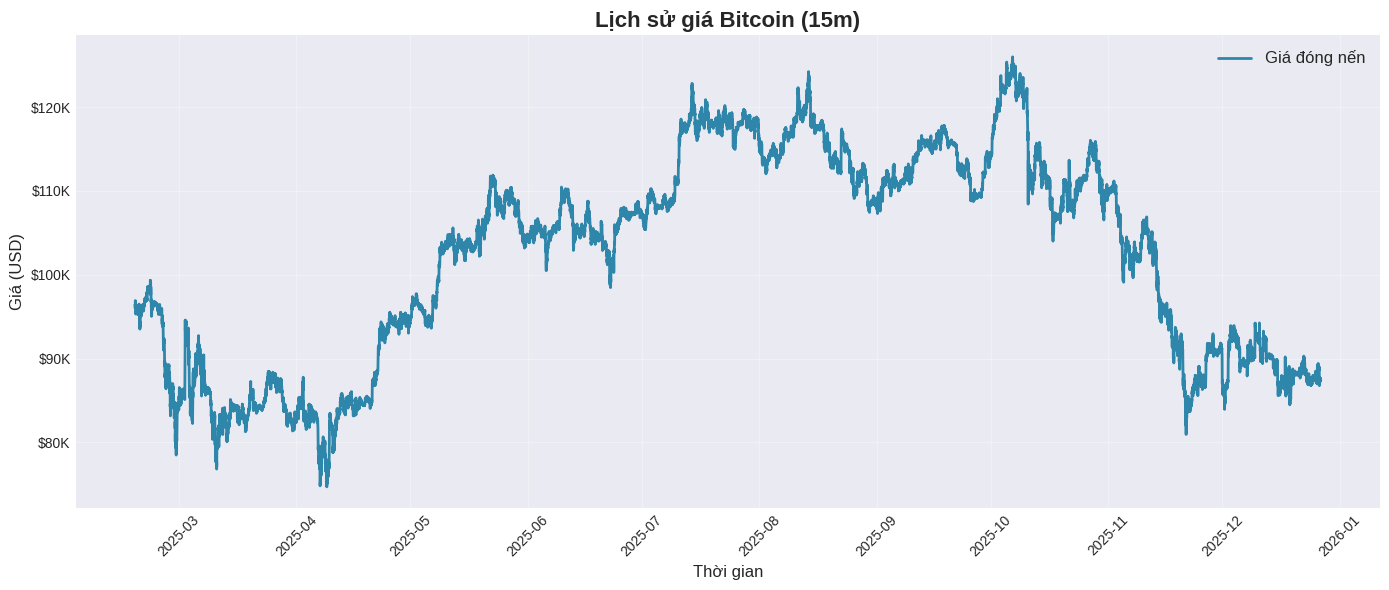

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['close'], linewidth=2, color='#2E86AB', label='Giá đóng nến')
plt.title(f'Lịch sử giá Bitcoin ({TIMEFRAME})', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

---

## 🔨 BƯỚC 2: XỬ LÝ DỮ LIỆU

### Giải thích:
- **Scaling**: Đưa dữ liệu về khoảng [0, 1] để model học tốt hơn
- **Chống data leakage**: scaler được **fit chỉ trên tập train**, sau đó mới transform val/test
- **Sliding Window**: Tạo sequences (window_size nến trước → dự đoán nến tiếp theo)
- **Split Data**: Chia thành train (70%), val (15%), test (15%)

In [6]:
from src.core import prepare_data_for_lstm  # noqa: E402

# Pipeline xử lý dữ liệu hoàn chỉnh
data_dict = prepare_data_for_lstm(
    df=df,
    features=config.data.features,
    window_size=config.preprocessing.window_size,
    scaler_type='minmax'
)

# Lấy các biến
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']
X_test = data_dict['X_test']
y_test = data_dict['y_test']
scaler = data_dict['scaler']

# Đánh dấu checklist
print("\n✅ Bước 2 hoàn thành!")


🔧 CHUẨN BỊ DỮ LIỆU CHO LSTM

📊 Shape dữ liệu gốc: (30000, 1)
   Features: ['close']
✅ Đã fit và transform dữ liệu với minmax scaler
   Min: 0.0000, Max: 1.0000
✅ Chia dữ liệu:
   Train: 21000 mẫu (70%)
   Val:   4500 mẫu (15%)
   Test:  4500 mẫu (15%)

✅ Dữ liệu sau khi tạo windows:
   X_train: (20856, 144, 1), y_train: (20856, 1, 1)
   X_val:   (4356, 144, 1), y_val: (4356, 1, 1)
   X_test:  (4356, 144, 1), y_test: (4356, 1, 1)


✅ Bước 2 hoàn thành!


### Kiểm tra shapes của dữ liệu

In [7]:
print("\n" + "="*60)
print("📊 SHAPES CỦA DỮ LIỆU")
print("="*60)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")
print("="*60 + "\n")


📊 SHAPES CỦA DỮ LIỆU
X_train: (20856, 144, 1)
y_train: (20856, 1, 1)
X_val:   (4356, 144, 1)
y_val:   (4356, 1, 1)
X_test:  (4356, 144, 1)
y_test:  (4356, 1, 1)



---

## 🧠 BƯỚC 3: XÂY DỰNG MODEL BiLSTM

### Giải thích:
- **BiLSTM**: LSTM hai chiều (nhìn cả quá khứ và tương lai)
- **Dropout**: Bỏ ngẫu nhiên neurons để tránh overfitting
- **Dense layers**: Kết hợp features để đưa ra dự đoán

In [8]:
from src.core import build_bilstm_model, print_model_summary  # noqa: E402

# Xây dựng model
input_shape = (config.preprocessing.window_size, len(config.data.features))
model = build_bilstm_model(
    input_shape=input_shape,
    lstm_units=config.model.lstm_units,
    dropout_rate=config.model.dropout_rate,
    dense_units=config.model.dense_units,
    output_units=1
)

# In thông tin model
print_model_summary(model)

# Đánh dấu checklist
print("\n✅ Bước 3 hoàn thành!")

✅ Đã build model BiLSTM với 2 LSTM layers

🧠 MODEL SUMMARY


Model: "BiLSTM_Price_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 144, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_dropout_1 (Dropout)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,121 (301.25 KB)

 Trainable params: 77,121 (301.25 KB)

 Non-trainable params: 0 (0.00 B)


📊 Thống kê:
   Total parameters: 77,121
   Trainable: 77,121
   Non-trainable: 0

✅ Bước 3 hoàn thành!


---

## 🏋️ BƯỚC 4: TRAINING MODEL

### Giải thích:
- **ModelCheckpoint**: Lưu lại model tốt nhất
- **EarlyStopping**: Dừng nếu val_loss không giảm
- **ReduceLROnPlateau**: Giảm learning rate nếu không cải thiện

In [9]:
from src.training import train_model  # noqa: E402

# Training
train_result = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    config=config
)

# Lấy training history
history = train_result['history']

# Metadata training (để đưa vào report)
best_epoch = train_result.get('best_epoch')
best_val_loss = train_result.get('best_val_loss')
train_seconds = train_result.get('train_seconds')
checkpoint_path_raw = train_result.get('checkpoint_path')
checkpoint_path = str(checkpoint_path_raw) if checkpoint_path_raw is not None else None

print(f"\n📌 Best epoch: {best_epoch}")
print(f"📌 Best val_loss: {best_val_loss}")
print(f"📌 Training time (s): {train_seconds}")

# Đánh dấu checklist
print("\n✅ Bước 4 hoàn thành!")


🚀 BẮT ĐẦU TRAINING
Epochs: 25
Batch size: 32
Train samples: 20856
Val samples: 4356
Checkpoint: /home/ultimatebrok/Downloads/deep_learning/models/checkpoints/best_model.keras



Epoch 1/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0183 - mae: 0.0836
Epoch 1: val_loss improved from None to 0.00066, saving model to /home/ultimatebrok/Downloads/deep_learning/models/checkpoints/best_model.keras

Epoch 1: finished saving model to /home/ultimatebrok/Downloads/deep_learning/models/checkpoints/best_model.keras
652/652 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - loss: 0.0073 - mae: 0.0570 - val_loss: 6.6432e-04 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 2/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0029 - mae: 0.0396
Epoch 2: val_loss did not improve from 0.00066
652/652 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - loss: 0.0027 - mae: 0.0383 - val_loss: 7.3307e-04 - val_mae: 0.0225 - learning_rate: 0.0010
Epoch 3/25
651/652 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0021 - mae: 0.0347
Epoch 3: val_loss improved from 0.00066 to 0.00036, saving model to /home/ultimatebrok/Downloads/deep_learning/models/checkpoints/best_model.keras

Epoch 3: finished saving mo

### Vẽ biểu đồ training history

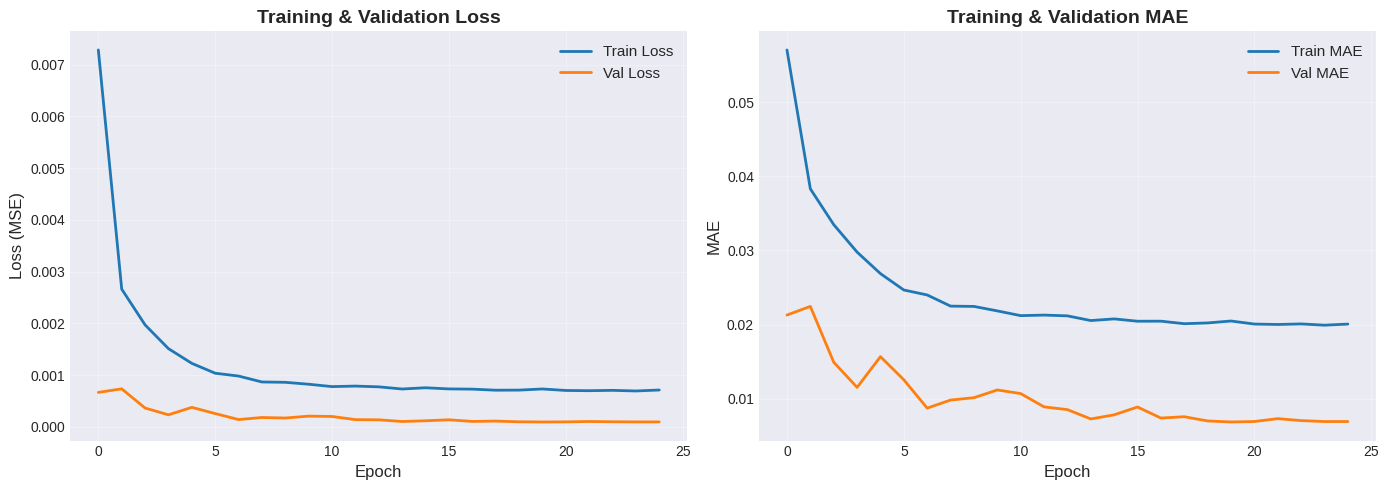

In [10]:
from src.visualization import plot_training_history  # noqa: E402

plot_training_history(history)

---

## 📊 BƯỚC 5: ĐÁNH GIÁ & VẼ BIỂU ĐỒ

### Giải thích:
- **MAE**: Sai số trung bình tuyệt đối (USD)
- **RMSE**: Căn bậc 2 của sai số bình phương trung bình (USD)
- **MAPE**: Sai số phần trăm trung bình (%)

In [11]:
from src.core import (  # noqa: E402
    calculate_direction_accuracy,
    evaluate_model,
    print_sample_predictions
)
from src.visualization import plot_all_in_one, plot_predictions  # noqa: E402

# Đánh giá trên test set
eval_result = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler,
    return_predictions=True
)

# Lấy dự đoán và giá trị thật
y_true = eval_result['y_true']
y_pred = eval_result['predictions']


📊 KẾT QUẢ ĐÁNH GIÁ TRÊN TEST SET
MAE:  $403.10  (Sai số trung bình tuyệt đối)
RMSE: $541.32  (Căn bậc 2 sai số bình phương)
MAPE: 0.45%  (Sai số phần trăm trung bình)



In [12]:
# In một số ví dụ dự đoán
print_sample_predictions(y_true, y_pred, n_samples=10)


VÍ DỤ DỰ ĐOÁN (đầu 10 mẫu)
STT   Thực tế         Dự đoán         Sai số          % Sai số    
------------------------------------------------------------
1     $104560.16     $104423.24     $136.92        0.13     %
2     $103982.20     $104459.12     $476.92        0.46     %
3     $103706.55     $104378.74     $672.19        0.65     %
4     $103518.97     $104247.20     $728.23        0.70     %
5     $103455.99     $104090.52     $634.53        0.61     %
6     $103523.13     $103958.52     $435.39        0.42     %
7     $103413.99     $103866.34     $452.35        0.44     %
8     $103508.01     $103781.81     $273.80        0.26     %
9     $103399.43     $103741.78     $342.35        0.33     %
10    $103569.97     $103697.03     $127.06        0.12     %



In [13]:
# Tính độ chính xác xu hướng
direction_accuracy = calculate_direction_accuracy(y_true, y_pred)

# Lưu vào eval_result để report/metrics.json có thêm thông tin
eval_result['direction_accuracy'] = float(direction_accuracy)

📈 Độ chính xác xu hướng: 50.95%


### Vẽ biểu đồ predictions vs actual

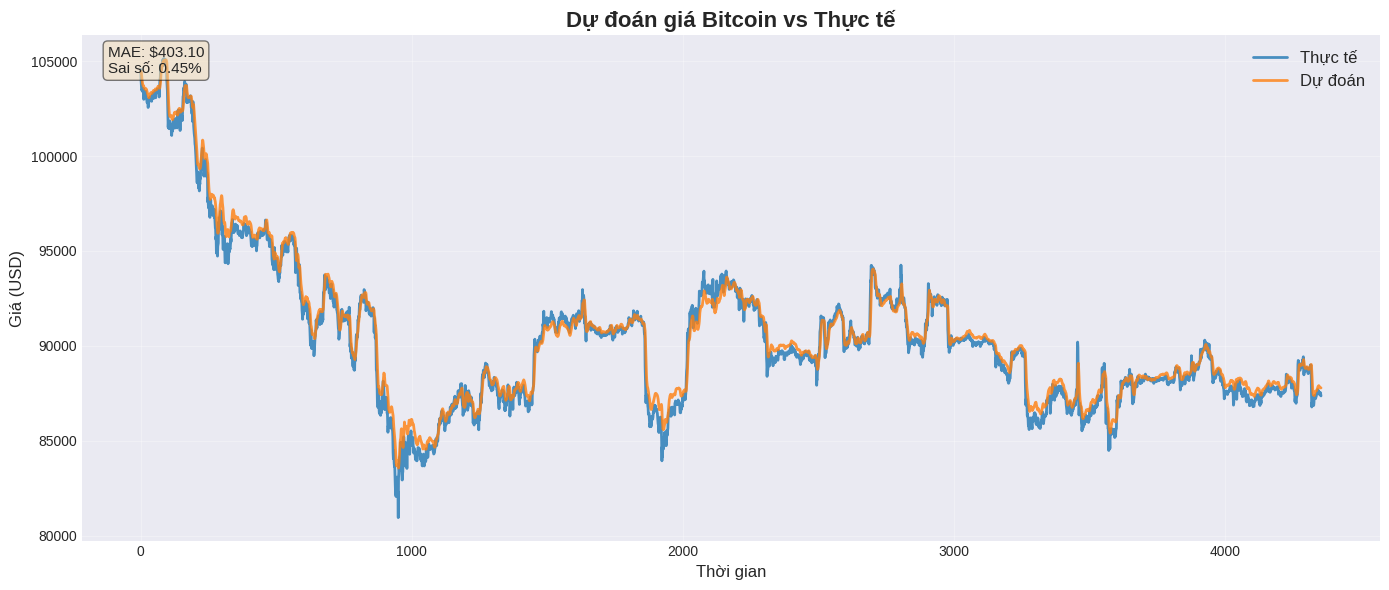

In [14]:
plot_predictions(y_true, y_pred)

### Vẽ biểu đồ tổng hợp (all-in-one)

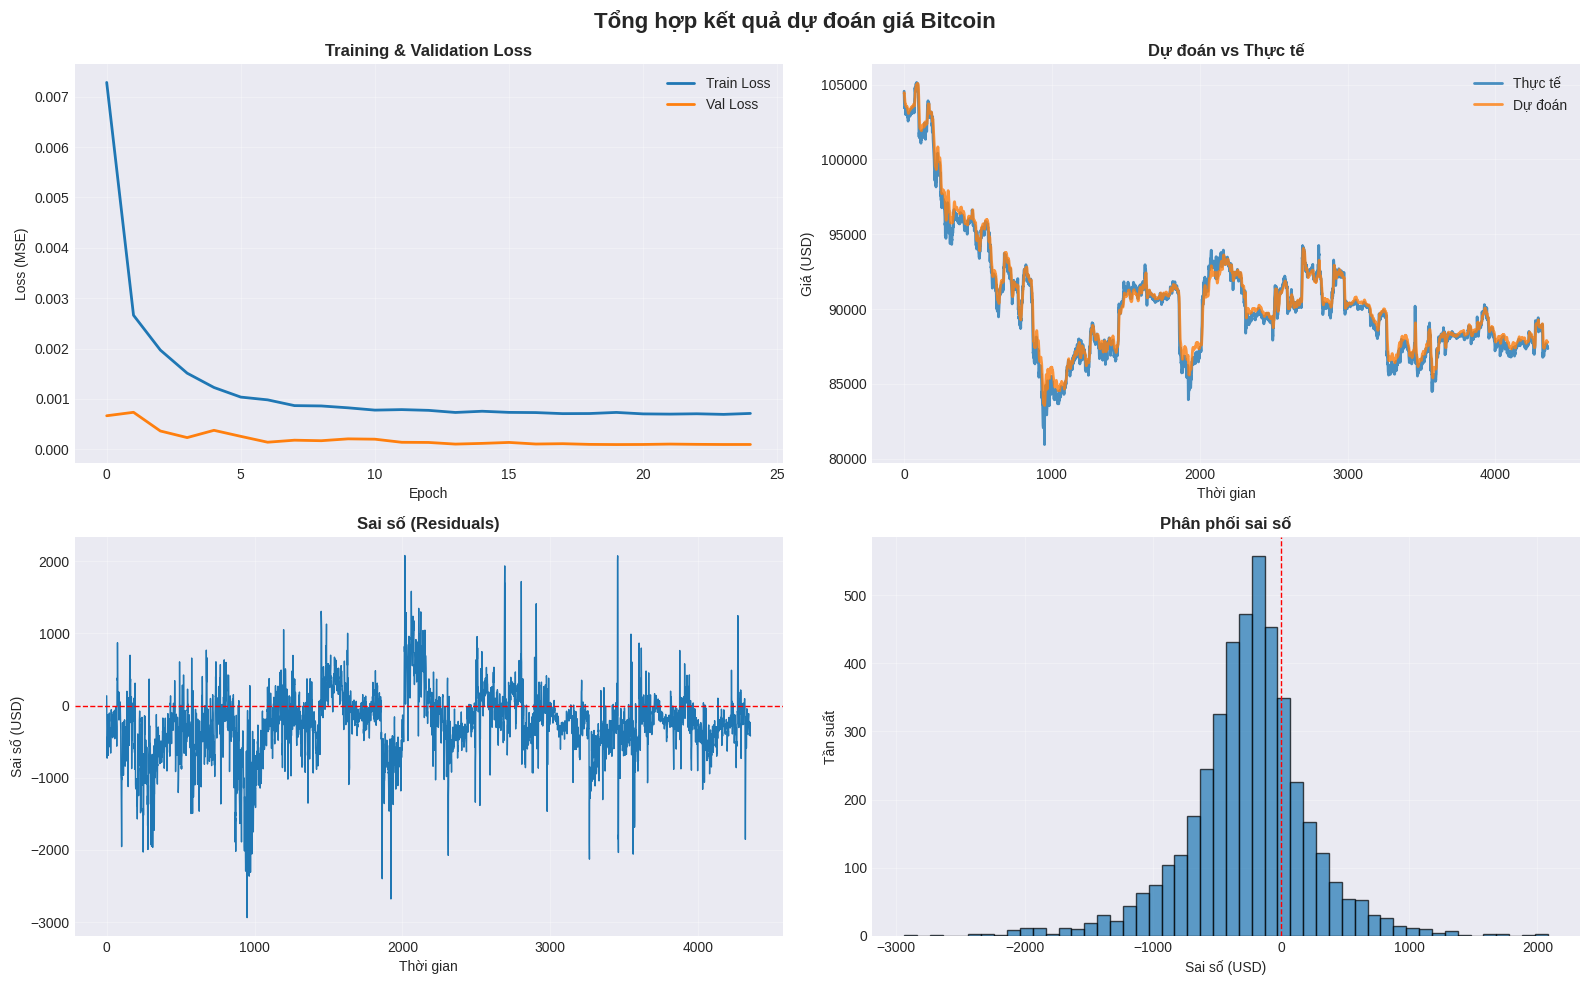

In [15]:
plot_all_in_one(history, y_true, y_pred)

---

## 💾 LƯU KẾT QUẢ

Tất cả kết quả được lưu vào thư mục `reports/notebook/`

📁 Folder kết quả: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714

💾 Đã lưu training history plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714/training_history_20251228_164714.png


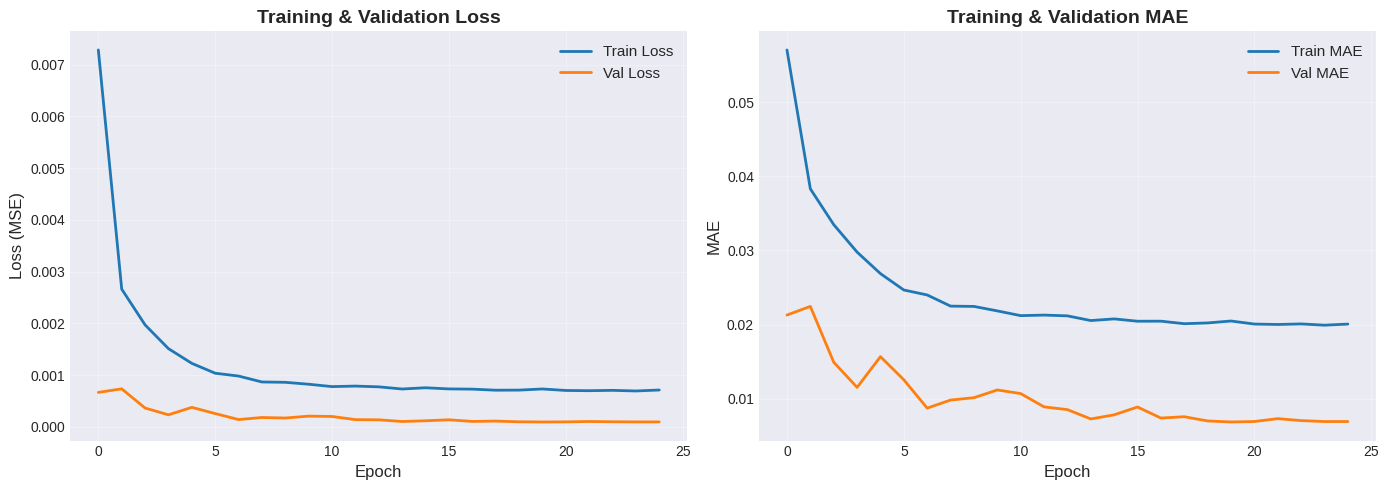

💾 Đã lưu predictions plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714/predictions_20251228_164714.png


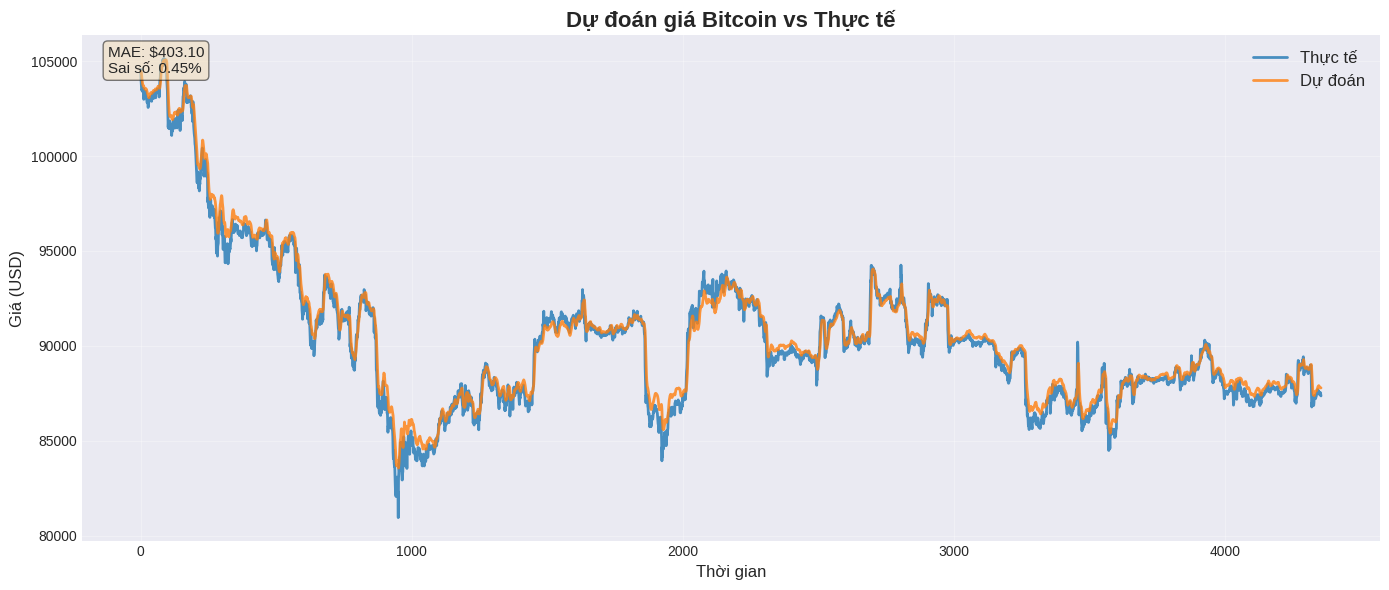

💾 Đã lưu all-in-one plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714/all_in_one_20251228_164714.png


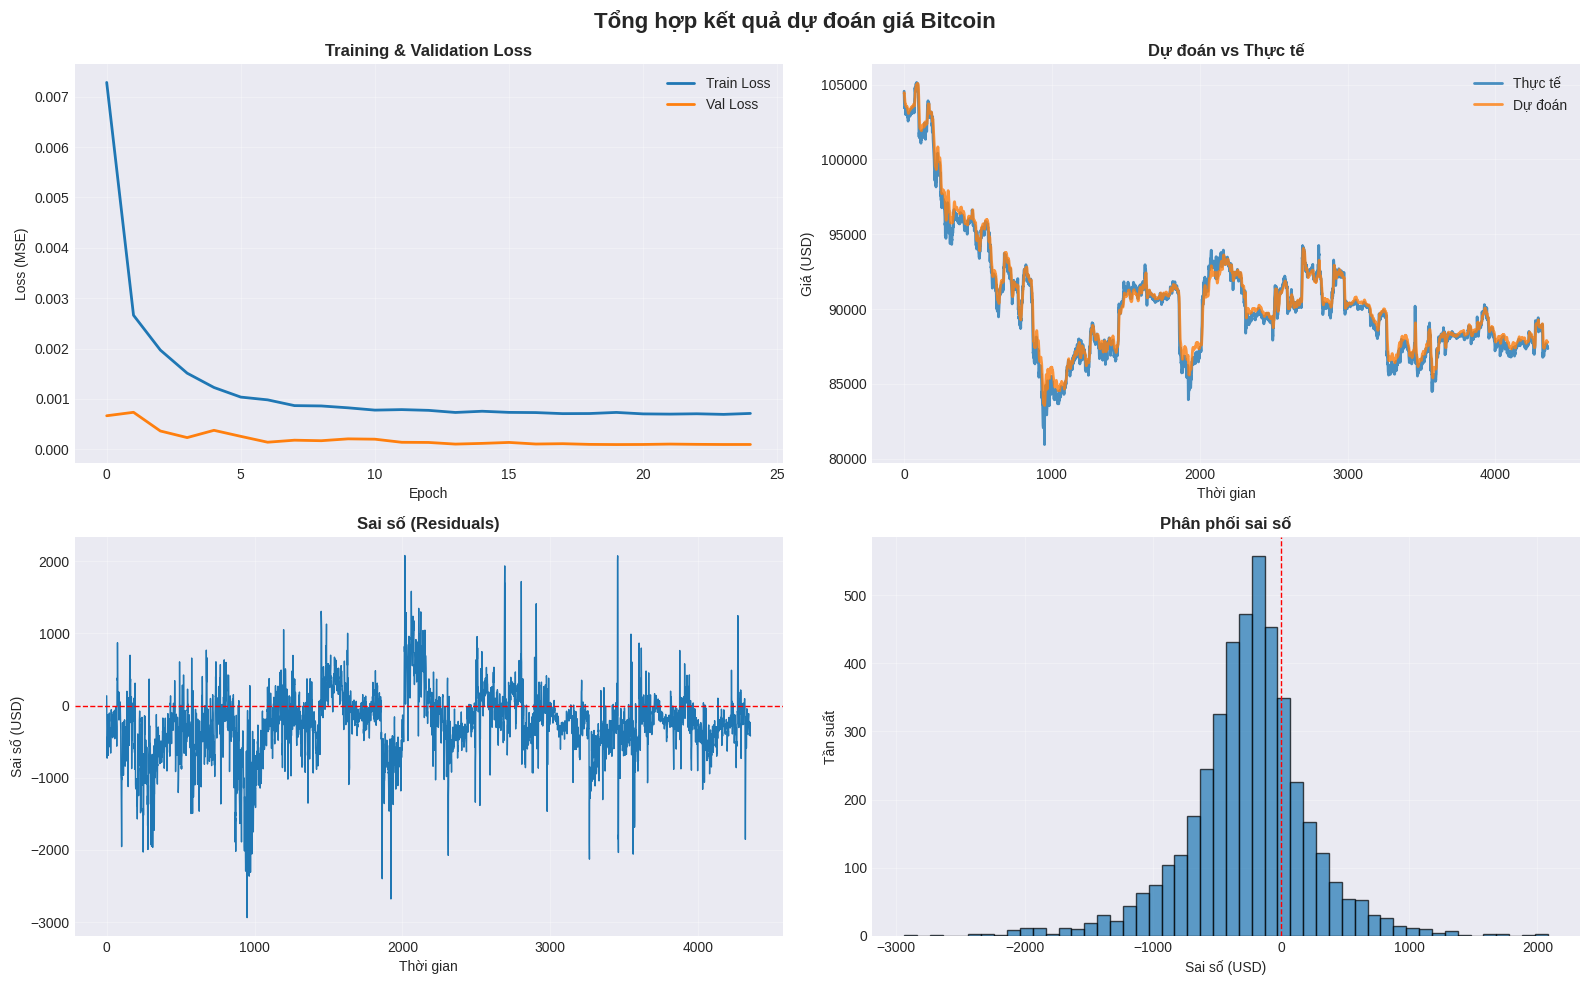

💾 Đã lưu báo cáo: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714/results_BiLSTM_15m_w144_l30k_20251228_164714.md
💾 Đã lưu config: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714/config.json
💾 Đã lưu metrics: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_15m_w144_l30k_20251228_164714/metrics.json

✅ Bước 5 hoàn thành!


In [16]:
from src.results import (  # noqa: E402
    create_results_folder,
    save_config,
    save_markdown_report,
    save_metrics
)

# Tạo folder kết quả với config để đặt tên chuẩn hóa
folder_config = {
    'timeframe': TIMEFRAME,
    'window_size': config.preprocessing.window_size,
    'limit': config.data.limit
}
results_folder = create_results_folder(run_type="notebook", config=folder_config)
print(f"📁 Folder kết quả: {results_folder}\n")

# Tạo suffix cho tên file (lấy timestamp từ tên folder: 2 phần cuối)
folder_parts = results_folder.name.split('_')
timestamp_suffix = '_'.join(folder_parts[-2:])  # Lấy 2 phần cuối (YYYYMMDD_HHMMSS)

# Vẽ và lưu biểu đồ
plot_history_file = results_folder / f"training_history_{timestamp_suffix}.png"
plot_predictions_file = results_folder / f"predictions_{timestamp_suffix}.png"
plot_all_in_one_file = results_folder / f"all_in_one_{timestamp_suffix}.png"

plot_training_history(history, save_path=str(plot_history_file))
plot_predictions(y_true, y_pred, save_path=str(plot_predictions_file))
plot_all_in_one(history, y_true, y_pred, save_path=str(plot_all_in_one_file))

# Metadata dữ liệu
try:
    data_rows = len(df)
    data_start = str(df.select('datetime').row(0)[0])
    data_end = str(df.select('datetime').row(-1)[0])
except Exception:
    data_rows = None
    data_start = None
    data_end = None

# Metadata split
train_samples = len(X_train)
val_samples = len(X_val)
test_samples = len(X_test)
scaler_type = 'minmax'

# Chuẩn bị config và metrics
config_dict = {
    'data_path': DATA_PATH,
    'symbol': SYMBOL,
    'timeframe': TIMEFRAME,
    'limit': config.data.limit,
    'data_rows': data_rows,
    'data_start': data_start,
    'data_end': data_end,
    'window_size': config.preprocessing.window_size,
    'features': config.data.features,
    'scaler_type': scaler_type,
    'train_samples': train_samples,
    'val_samples': val_samples,
    'test_samples': test_samples,
    'seed': config.runtime.seed,
    'lstm_units': config.model.lstm_units,
    'dropout_rate': config.model.dropout_rate,
    'epochs': config.training.epochs,
    'batch_size': config.training.batch_size,
    'early_stopping_patience': config.training.early_stopping_patience,
    'learning_rate': config.training.learning_rate,
    'intra_threads': config.runtime.intra_op_threads,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'train_seconds': train_seconds,
    'checkpoint_path': checkpoint_path,
}

plots_dict = {
    'training_history': f"training_history_{timestamp_suffix}.png",
    'predictions': f"predictions_{timestamp_suffix}.png",
    'all_in_one': f"all_in_one_{timestamp_suffix}.png"
}

# Lưu báo cáo
save_markdown_report(
    folder_path=results_folder,
    config=config_dict,
    metrics=eval_result,
    history=history.history,
    plots=plots_dict
)
save_config(results_folder, config_dict)
save_metrics(results_folder, eval_result)

# Đánh dấu checklist
print("\n✅ Bước 5 hoàn thành!")

---

## 🎉 HOÀN THÀNH!

### Checklist:
- [x] Bước 0: Setup & Cấu hình
- [x] Bước 1: Đọc dữ liệu CSV (local)
- [x] Bước 2: Xử lý dữ liệu
- [x] Bước 3: Xây dựng model BiLSTM
- [x] Bước 4: Training model
- [x] Bước 5: Đánh giá & Vẽ biểu đồ
- [x] Bước 6: Lưu kết quả

### Kết quả:
- Báo cáo Markdown: `reports/notebook/BiLSTM_YYYYMMDD_HHMMSS/results_*.md`
- Biểu đồ: Các file PNG trong cùng folder
- Config & Metrics: File JSON trong cùng folder

### Tiếp theo:
- Thử thay đổi preset:
  - **Scalping (15m):** scalping-ultra-fast, scalping-fast
  - **Intraday (15m):** intraday-light, intraday-balanced
  - **Swing (15m):** swing-fast, swing-balanced
  - **Long-term (15m):** long-term
  - **Production (15m):** production
  - **30k Dataset (15m - Window size từ ngắn đến dài hạn, intra_op_threads=12):**
    - 30k-w24, 30k-w48, 30k-w72, 30k-w96, 30k-w144, 30k-w192, 30k-w240, 30k-w336, 30k-w480, 30k-w672
  - **Legacy (other timeframes):** default, fast, 1h-light, 4h-balanced
- Hoặc cấu hình thủ công bằng cách set PRESET_NAME = None
- Thêm các features khác (volume, open, high, low)
- Thử timeframe khác (1d, 4h, 1h, 15m) - default là 15m

**Chúc bạn thành công! 🚀**